In [1]:
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn

# modeling
from sklearn.cluster import KMeans

# 1. User behavior
### 1a. Product ordering frequency (how often? when? )
- **Nbr_order**: number of unique orders per each user
- **avg_days_bt_orders** : avg days between orders
- **nbr_order_weekends, nbr_order_weekday** : Number of order made in weekends, number of order made in weekdays
- **percent_order_weekends**: percentage of order made in weekends, percentage of order made in weekdays
- **nbr_order_peak, percent_order_peak:** orders made during 9-17
- **nbr_order_offpeak, percent_order_offpeak:** orders made during 7-8 and 16-22
- **nbr_order_unsual, percent_order_unsual:** order made during 23-6

In [2]:
df= pd.read_csv('data/orders.csv')
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
df.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [4]:
#number of unique user_id, include: train & test
len(df.user_id.unique())

206209

In [5]:
len(df.order_id.unique())

3421083

In [6]:
print(df.shape)
# each row is a unique order ID

(3421083, 7)


- **Nbr_order**: number of unique orders per each user
- **avg_days_bt_orders** : avg days between orders

In [7]:
df1= df.groupby('user_id').agg({'order_id':'count','days_since_prior_order': 'mean'}).round(2). reset_index()
df1.head()

,user_id,order_id,days_since_prior_order
0,1,11,19.00
1,2,15,16.29
2,3,13,12.00
3,4,6,17.00
4,5,5,11.50


In [8]:
df1.columns =['user_id','nbr_order','mean_days_bt_order']
df1.head()

,user_id,nbr_order,mean_days_bt_order
0,1,11,19.00
1,2,15,16.29
2,3,13,12.00
3,4,6,17.00
4,5,5,11.50


In [9]:
df1.shape

(206209, 3)

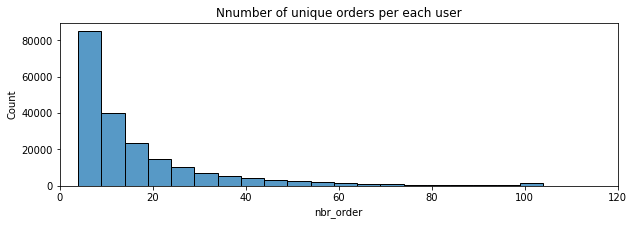

In [10]:
plt.figure(figsize=(10,3))
sns.histplot(df1.nbr_order,binwidth = 5)
plt.xlim(0,120)
plt.title('Nnumber of unique orders per each user');

Text(0.5, 1.0, 'avg days between orders')

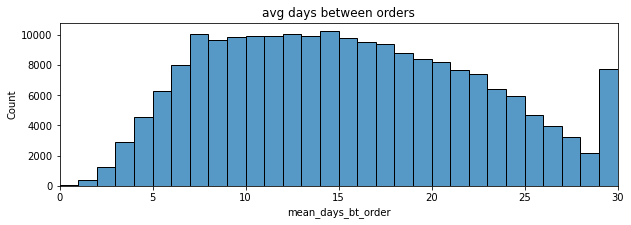

In [11]:
plt.figure(figsize=(10,3))
sns.histplot(df1.mean_days_bt_order,binwidth = 1)
plt.xlim(0,30)
plt.title('avg days between orders')

- **nbr_order_weekends, nbr_order_weekday** : Number of order made in weekends, number of order made in weekdays
- **percent_order_weekends**: percentage of order made in weekends, percentage of order made in weekdays

In [12]:
df2= df.groupby(['user_id','order_dow'],as_index=False).order_id.count()
df2.head()

,user_id,order_dow,order_id
0,1,1,3
1,1,2,2
2,1,3,2
3,1,4,4
4,2,1,6


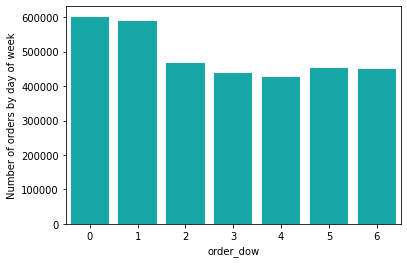

In [13]:
sns.barplot(data=df2,x='order_dow', y='order_id',ci=None,color='c',estimator=sum)
plt.ylabel('Number of orders by day of week');

In [14]:
df2['dow']= np.where((df2.order_dow ==0) | (df2.order_dow ==1), 'weekend','weekdays')
df2.head()

,user_id,order_dow,order_id,dow
0,1,1,3,weekend
1,1,2,2,weekdays
2,1,3,2,weekdays
3,1,4,4,weekdays
4,2,1,6,weekend


In [15]:
df2= df2.groupby(['user_id','dow'], as_index=False).order_id.sum()
df2.head()

,user_id,dow,order_id
0,1,weekdays,8
1,1,weekend,3
2,2,weekdays,9
3,2,weekend,6
4,3,weekdays,5


In [16]:
df2= df2.pivot(index= 'user_id',columns= 'dow', values='order_id').fillna(0).reset_index()

In [17]:
df2.columns= ['user_id','nbr_order_weekends', 'nbr_order_weekday']
df2.head()

,user_id,nbr_order_weekends,nbr_order_weekday
0,1,8.0,3.0
1,2,9.0,6.0
2,3,5.0,8.0
3,4,6.0,0.0
4,5,2.0,3.0


In [18]:
df2['percent_order_weekends']=(df2.nbr_order_weekends /(df2.nbr_order_weekends +df2.nbr_order_weekday) *100).round(2)

In [19]:
df2.head()

,user_id,nbr_order_weekends,nbr_order_weekday,percent_order_weekends
0,1,8.0,3.0,72.73
1,2,9.0,6.0,60.00
2,3,5.0,8.0,38.46
3,4,6.0,0.0,100.00
4,5,2.0,3.0,40.00


- **nbr_order_peak, percent_order_peak:** orders made during 9-17
- **nbr_order_offpeak, percent_order_offpeak:** orders made during 7-8 and 16-22
- **nbr_order_unsual, percent_order_unsual:** order made during 23-6

In [20]:
df3= df.groupby(['user_id','order_hour_of_day'],as_index=False).order_id.count()
df3.head()

,user_id,order_hour_of_day,order_id
0,1,7,3
1,1,8,3
2,1,9,1
3,1,12,1
4,1,14,1


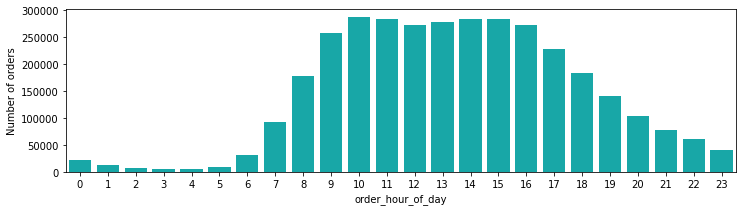

In [21]:
plt.figure(figsize=(12,3))
sns.barplot(data=df3,x='order_hour_of_day', y='order_id',ci= None,color='c',estimator=sum)
plt.ylabel('Number of orders');

In [22]:
df3['order_time']= np.where((df3.order_hour_of_day >=9) & (df3.order_hour_of_day <=17), 'peak',
         np.where((df3.order_hour_of_day >=23) | (df3.order_hour_of_day <=6),'unusual','off-peak'))

In [23]:
df3= df3.groupby(['user_id','order_time'],as_index=False).order_id.sum()
df3.head()

,user_id,order_time,order_id
0,1,off-peak,6
1,1,peak,5
2,2,peak,15
3,3,off-peak,3
4,3,peak,10


In [24]:
df3= df3.pivot(index= 'user_id',columns= 'order_time', values='order_id').fillna(0).reset_index()
df3.head()

order_time,user_id,off-peak,peak,unusual
0,1,6.0,5.0,0.0
1,2,0.0,15.0,0.0
2,3,3.0,10.0,0.0
3,4,0.0,6.0,0.0
4,5,2.0,3.0,0.0


In [25]:
df3.columns=['user_id','nbr_order_offpeak','nbr_order_peak','nbr_order_unusual']
df3.head()

,user_id,nbr_order_offpeak,nbr_order_peak,nbr_order_unusual
0,1,6.0,5.0,0.0
1,2,0.0,15.0,0.0
2,3,3.0,10.0,0.0
3,4,0.0,6.0,0.0
4,5,2.0,3.0,0.0


In [26]:
df3['percent_order_offpeak']=(df3.nbr_order_offpeak/(df3.nbr_order_offpeak + df3.nbr_order_peak + df3.nbr_order_unusual)
                              *100).round(2)
df3['percent_order_peak']=(df3.nbr_order_peak/(df3.nbr_order_offpeak + df3.nbr_order_peak + df3.nbr_order_unusual)
                              *100).round(2)
df3['percent_order_unnusual']=(df3.nbr_order_unusual/(df3.nbr_order_offpeak + df3.nbr_order_peak + df3.nbr_order_unusual)
                              *100).round(2)

In [27]:
df3.head()

,user_id,nbr_order_offpeak,nbr_order_peak,nbr_order_unusual,percent_order_offpeak,percent_order_peak,percent_order_unnusual
0,1,6.0,5.0,0.0,54.55,45.45,0.0
1,2,0.0,15.0,0.0,0.00,100.00,0.0
2,3,3.0,10.0,0.0,23.08,76.92,0.0
3,4,0.0,6.0,0.0,0.00,100.00,0.0
4,5,2.0,3.0,0.0,40.00,60.00,0.0


- **Combine data**

In [28]:
df_user= df1.merge(df2, how='inner').merge(df3, how='inner')
df_user.head()

,user_id,nbr_order,mean_days_bt_order,nbr_order_weekends,nbr_order_weekday,percent_order_weekends,nbr_order_offpeak,nbr_order_peak,nbr_order_unusual,percent_order_offpeak,percent_order_peak,percent_order_unnusual
0,1,11,19.00,8.0,3.0,72.73,6.0,5.0,0.0,54.55,45.45,0.0
1,2,15,16.29,9.0,6.0,60.00,0.0,15.0,0.0,0.00,100.00,0.0
2,3,13,12.00,5.0,8.0,38.46,3.0,10.0,0.0,23.08,76.92,0.0
3,4,6,17.00,6.0,0.0,100.00,0.0,6.0,0.0,0.00,100.00,0.0
4,5,5,11.50,2.0,3.0,40.00,2.0,3.0,0.0,40.00,60.00,0.0


In [29]:
#filter only user id for train data
df_user= pd.DataFrame(df[df.eval_set == "train"].user_id).merge(df_user,how='left')
print(df_user.shape)

(131209, 12)


----------

# 1. User behavior
### 1b. Purchase type (loyal vs. trial)
Product level
- **basket_size:** avg number of unique products per order 
- **reordered_ratio:** avg ratio of reorder products out of total basket size per order -> *(High -conservative users: tendency to reorder similar products b/w order- loyal to only a group of product items; Low - Trialist: try a wide range of products)*
- **nbr_unique_product_ordered:** total number unique product ever ordered (across all order) -> *(High: Trialists (try many product), Low : Conservative (stick to only a few product))*

Aisle level
- **nbr_unique_aisle_ordered:** total number unique aisle ever ordered (across all order) -> *willingness of trying new aisle*
- **ratio_aisle_ordered:** percentage of aisle ever ordered from out of total aisle -> *willingness of trying new aisle*

- **General understanding of store structure: 21 department -> 134 aisle -> 49688 products**

In [30]:
df_product= pd.read_csv('data/products.csv')
df_product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [31]:
df_product= df_product.merge(pd.read_csv('data/aisles.csv'),how='inner')
df_product.head()

,product_id,product_name,aisle_id,department_id,aisle
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes
2,102,Danish Butter Cookies,61,19,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes


In [32]:
product_per_aisle= df_product.groupby(['aisle_id','aisle']).product_id.count().reset_index().sort_values(
    'product_id',ascending=False)
product_per_aisle.columns= ['aisle_id','aisle','nbr_product_offer']
product_per_aisle.head()
# several aisle have more products than others -> more chance to be in users' order (more popular)? 

,aisle_id,aisle,nbr_product_offer
99,100,missing,1258
44,45,candy chocolate,1246
36,37,ice cream ice,1091
46,47,vitamins supplements,1038
119,120,yogurt,1026


- **General understanding of order dataset**: the data record only to product level for each order, no record of how many item of a specific product_id in each order

In [33]:
df4= pd.concat([pd.read_csv('data/order_products__prior.csv'),pd.read_csv('data/order_products__train.csv')])
df4.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [34]:
df4= df4.merge(pd.read_csv('data/products.csv'), how='left').merge(
    pd.read_csv('data/aisles.csv'),how='left').merge(
    df[['user_id','order_id']],how='inner').merge(
df_user[['user_id']],how='inner')
df4.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,user_id
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,202279
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,202279
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,202279
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,202279
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,202279


In [35]:
df4.user_id.nunique()

131209

In [36]:
# confirm that: the data record only to product level for each order
# no record of how many item of a specific product_id in each order
df4.groupby(['order_id','product_id']).add_to_cart_order.count().reset_index().sort_values(
    'add_to_cart_order',ascending=False)

,order_id,product_id,add_to_cart_order
0,1,10246,1
14684403,2280577,38164,1
14684411,2280578,10403,1
14684410,2280578,9366,1
14684409,2280578,9076,1
...,...,...,...
7342200,1141214,5422,1
7342199,1141214,5077,1
7342198,1141213,18382,1
7342197,1141213,2517,1


- **basket_size:** avg number of unique products per order
- **reordered_ratio:** avg ratio of reorder products out of total basket size per order (High -conservative users: tendency to reorder similar products b/w order- loyal to only a group of product items; Low - Trialist: try a wide range of products) 

In [37]:
df4.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,user_id
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,202279
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,202279
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,202279
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,202279
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,202279


In [38]:
df5= df4.groupby(['user_id','order_id'],as_index=False).agg({'product_id':'count','reordered': 'mean'})
df5.columns= ['user_id','order_id','basket_size','reordered_ratio']
df5.head()

,user_id,order_id,basket_size,reordered_ratio
0,1,431534,8,0.625000
1,1,473747,5,0.600000
2,1,550135,5,1.000000
3,1,1187899,11,0.909091
4,1,2254736,5,1.000000


In [39]:
df5[['basket_size','reordered_ratio']].describe().round(2)

,basket_size,reordered_ratio
count,2178586.00,2178586.00
mean,10.11,0.60
std,7.54,0.34
min,1.00,0.00
25%,5.00,0.33
50%,8.00,0.67
75%,14.00,0.90
max,145.00,1.00


In [40]:
# by order
df5.head()

,user_id,order_id,basket_size,reordered_ratio
0,1,431534,8,0.625000
1,1,473747,5,0.600000
2,1,550135,5,1.000000
3,1,1187899,11,0.909091
4,1,2254736,5,1.000000


In [41]:
# by user
df5= df5.groupby('user_id',as_index=False).agg(
    {'basket_size':'mean','reordered_ratio':'mean'})
df5.head()

,user_id,basket_size,reordered_ratio
0,1,6.363636,0.724311
1,2,15.066667,0.443903
2,5,9.200000,0.391111
3,7,10.238095,0.760666
4,8,16.750000,0.285043


In [42]:
df5.reordered_ratio= df5.reordered_ratio *100

In [43]:
df5.head()

,user_id,basket_size,reordered_ratio
0,1,6.363636,72.431129
1,2,15.066667,44.390335
2,5,9.200000,39.111111
3,7,10.238095,76.066630
4,8,16.750000,28.504274


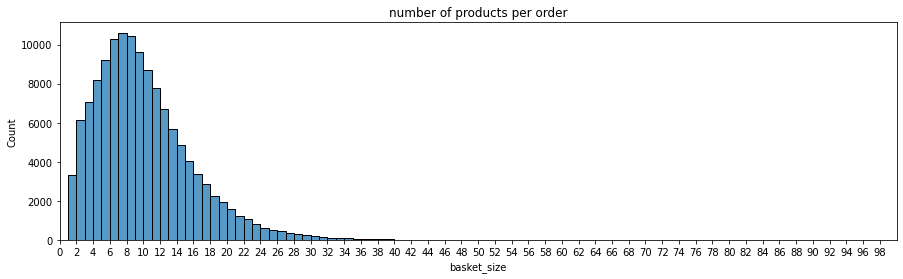

In [44]:
plt.figure(figsize=(15,4))
sns.histplot(df5.basket_size,binwidth = 1)
plt.xlim(1,100)
plt.xticks(np.arange(0,100,2))
plt.title('number of products per order');

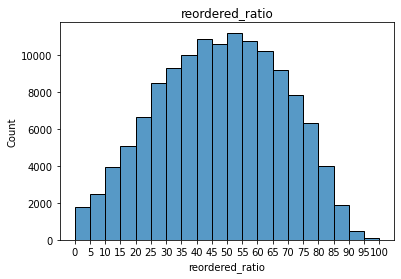

In [45]:
sns.histplot(df5.reordered_ratio,binwidth = 5)
plt.xticks(np.arange(0,101,5))
plt.title('reordered_ratio');

- **nbr_unique_product_ordered:** total number unique product ever ordered (across all order) -> (High: Trialists (try many product), Low : Conservative (stick to only a few product))

In [46]:
df6= df4.groupby('user_id',as_index=False).product_id.nunique()
df6.columns=['user_id','nbr_unique_product_ordered']
df6.head()

,user_id,nbr_unique_product_ordered
0,1,19
1,2,121
2,5,28
3,7,69
4,8,50


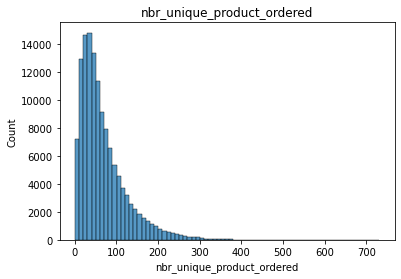

In [47]:
sns.histplot(df6.nbr_unique_product_ordered,binwidth = 10)
plt.title('nbr_unique_product_ordered');

- **nbr_unique_aisle_ordered:** total number unique aisle ever ordered (across all order) -> willingness of trying new aisle
- **ratio_aisle_ordered:** percentage of aisle ever ordered from out of total aisle 

In [48]:
df7= df4.groupby('user_id',as_index=False).aisle_id.nunique()
df7.columns=['user_id','nbr_unique_aisle_ordered']
df7.head()

,user_id,nbr_unique_aisle_ordered
0,1,13
1,2,37
2,5,17
3,7,34
4,8,19


In [49]:
df7['ratio_aisle_ordered']= (df7.nbr_unique_aisle_ordered/134*100).round()

In [50]:
df7.head()

,user_id,nbr_unique_aisle_ordered,ratio_aisle_ordered
0,1,13,10.0
1,2,37,28.0
2,5,17,13.0
3,7,34,25.0
4,8,19,14.0


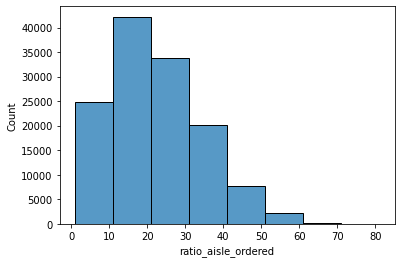

In [51]:
sns.histplot(df7['ratio_aisle_ordered'],binwidth = 10);

In [52]:
df4.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,user_id
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,202279
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,202279
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,202279
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,202279
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,202279


- **Combine data**

In [53]:
df_user= df_user.merge(df5,how='left').merge(df6,how='left').merge(df7,how='left')

In [54]:
df_user.head()

,user_id,nbr_order,mean_days_bt_order,nbr_order_weekends,nbr_order_weekday,percent_order_weekends,nbr_order_offpeak,nbr_order_peak,nbr_order_unusual,percent_order_offpeak,percent_order_peak,percent_order_unnusual,basket_size,reordered_ratio,nbr_unique_product_ordered,nbr_unique_aisle_ordered,ratio_aisle_ordered
0,1,11,19.00,8.0,3.0,72.73,6.0,5.0,0.0,54.55,45.45,0.0,6.363636,72.431129,19,13,10.0
1,2,15,16.29,9.0,6.0,60.00,0.0,15.0,0.0,0.00,100.00,0.0,15.066667,44.390335,121,37,28.0
2,5,5,11.50,2.0,3.0,40.00,2.0,3.0,0.0,40.00,60.00,0.0,9.200000,39.111111,28,17,13.0
3,7,21,10.45,10.0,11.0,47.62,6.0,15.0,0.0,28.57,71.43,0.0,10.238095,76.066630,69,34,25.0
4,8,4,23.33,2.0,2.0,50.00,1.0,1.0,2.0,25.00,25.00,50.0,16.750000,28.504274,50,19,14.0


In [55]:
#df_user.to_csv('df_users.csv')

--------

# 2. Product aisle preference

- **total product purchase by aisle for each users**

In [56]:
df4.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,user_id
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,202279
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,202279
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,202279
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,202279
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,202279


**hypothesis:** ailse with high products offered are more likely to be popular. ex: candy chocolate, ice cream ice
- nbr_product_ordered: total product ordered for each aisle
- nbr_product_reordered: total product reordered for each aisle
- nbr_unique_order: total unique orders for each aisle 
- ratio_out_of_total_order : penatration of each aisle out of all orders

**conclusion:** 
- nbr_product_ordered  have high correlation vs. nbr_unique_order vs. nbr_product_reordered -> 'popular aisle' means more likely to be ordered (high nbr of order, high nbr of products, high nbr of reorder)
- nbr_product_offer have weak correlation with nbr_unique_order & nbr_product_ordered & nbr_product_reordered-> ailse with high products offered doesn't mean they will be more likely to be popular

In [57]:
# number of product offered per aisle
# hypothesis: ailse with high products offered are more likely to be popular. ex: candy chocolate, ice cream ice
product_per_aisle.head()

,aisle_id,aisle,nbr_product_offer
99,100,missing,1258
44,45,candy chocolate,1246
36,37,ice cream ice,1091
46,47,vitamins supplements,1038
119,120,yogurt,1026


In [58]:
popular_aisle= df4.groupby(['aisle_id','aisle'],as_index=False).agg({'product_id':'count','reordered':'sum','order_id':'nunique'})
popular_aisle.columns=['aisle_id','aisle','nbr_product_ordered','nbr_product_reordered','nbr_unique_order']
popular_aisle.head()
#nbr_product_ordered: total product ordered for each aisle
#nbr_unique_order: total unique orders for each aisle 

,aisle_id,aisle,nbr_product_ordered,nbr_product_reordered,nbr_unique_order
0,1,prepared soups salads,48269,28577,42649
1,2,specialty cheeses,56638,27924,52983
2,3,energy granola bars,305230,182060,187186
3,4,instant foods,137259,67354,112876
4,5,marinades meat preparation,42805,12045,39967


In [59]:
popular_aisle['ratio_out_of_total_order']= popular_aisle.nbr_unique_order/ df4.order_id.nunique() *100
# ratio_out_of_total_order : penatration of each aisle out of all orders

In [60]:
popular_aisle= popular_aisle.merge(product_per_aisle,how='inner')

In [61]:
popular_aisle.head()

,aisle_id,aisle,nbr_product_ordered,nbr_product_reordered,nbr_unique_order,ratio_out_of_total_order,nbr_product_offer
0,1,prepared soups salads,48269,28577,42649,1.957646,146
1,2,specialty cheeses,56638,27924,52983,2.431990,271
2,3,energy granola bars,305230,182060,187186,8.592087,832
3,4,instant foods,137259,67354,112876,5.181159,543
4,5,marinades meat preparation,42805,12045,39967,1.834539,409


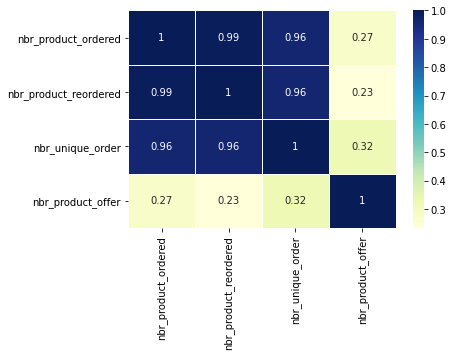

In [62]:
sns.heatmap(popular_aisle[['nbr_product_ordered','nbr_product_reordered','nbr_unique_order','nbr_product_offer']].corr(),
            linewidths=0.5,cbar=True,cmap='YlGnBu',annot=True)
plt.xticks(rotation=90)
plt.show()
# nbr_product_ordered  have high correlation vs. nbr_unique_order vs. nbr_product_reordered 
# -> 'popular aisle' means more likely to be ordered, high nbr of order, high nbr of products, high nbr of reorder
# nbr_product_offer have weak correlation with nbr_unique_order & nbr_product_ordered 
# -> ailse with high products offered doesn't mean they will be more likely to be picked

In [63]:
popular_aisle.sort_values('ratio_out_of_total_order',ascending=False)
# several popular aisle doesn't have many product offer

,aisle_id,aisle,nbr_product_ordered,nbr_product_reordered,nbr_unique_order,ratio_out_of_total_order,nbr_product_offer
23,24,fresh fruits,2467078,1773429,1212510,55.655824,382
82,83,fresh vegetables,2332313,1388314,970513,44.547840,569
122,123,packaged vegetables fruits,1201242,767997,800744,36.755216,615
119,120,yogurt,985207,678024,572191,26.264329,1026
83,84,milk,598119,467688,529043,24.283779,243
...,...,...,...,...,...,...,...
43,44,eye ear care,6308,1414,6050,0.277703,113
81,82,baby accessories,5530,3064,5470,0.251080,44
101,102,baby bath body care,5724,1648,5317,0.244057,132
131,132,beauty,4281,933,4069,0.186773,178


In [64]:
#popular_aisle.to_csv('popular_aisle.csv')

- **per order:** number of product by aisle

In [65]:
df8 = df4.groupby(['order_id','aisle_id','aisle'],as_index=False).product_id.count()
df8.head()

,order_id,aisle_id,aisle,product_id
0,1,21,packaged cheese,1
1,1,24,fresh fruits,2
2,1,83,fresh vegetables,2
3,1,95,canned meat seafood,1
4,1,108,other creams cheeses,1


In [66]:
df8= df8.pivot(index= 'order_id',columns= 'aisle', values='product_id').fillna(0).reset_index()
df8.head()

aisle,order_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


- **per users:** total product purchase by aisle 

In [67]:
df_aisle= df[['user_id','order_id']].merge(df8,how='inner')
df_aisle.head()

,user_id,order_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,1,2539329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2398795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,473747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2254736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,431534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df_aisle= df_aisle.groupby('user_id',as_index=False).sum()
df_aisle.head()

,user_id,order_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,1,21157951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,26521571,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0
2,5,9247893,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,7,37423230,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,8,7030886,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# let ignore user id in test data for now
df_aisle= df_user[['user_id']].merge(df_aisle,how='left')
df_aisle.shape

(131209, 136)

In [70]:
df_aisle.drop('order_id',axis=1,inplace=True)

In [71]:
#df_aisle.to_csv('df_aisle.csv')

---------------

In [72]:
df_frequency= pd.read_csv('data/orders.csv').merge(df_user[['user_id']],how='right')

In [73]:
df_frequency.user_id.nunique()

131209

In [74]:
df_frequency.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [75]:
#df_frequency.to_csv('df_frequency.csv')

In [76]:
pd.crosstab(df.order_hour_of_day,df['order_dow'], dropna=False,margins=True)

order_dow,0,1,2,3,4,5,6,All
order_hour_of_day,,,,,,,,
0,3936,3674,3059,2952,2642,3189,3306,22758
1,2398,1830,1572,1495,1512,1672,1919,12398
2,1409,1105,943,953,899,1016,1214,7539
3,963,748,719,654,686,841,863,5474
4,813,809,744,719,730,910,802,5527
5,1168,1607,1399,1355,1330,1574,1136,9569
6,3329,5370,4758,4562,4401,4866,3243,30529
7,12410,16571,13245,12396,12493,13434,11319,91868
8,28108,34116,24635,22553,21814,24015,22960,178201


<AxesSubplot:xlabel='order_hour_of_day', ylabel='order_dow'>

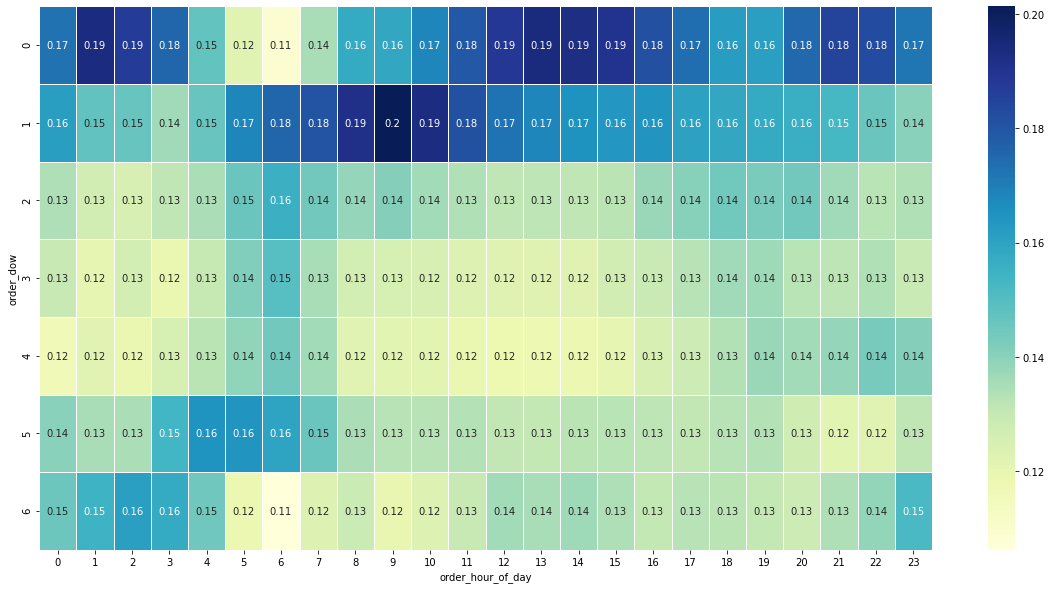

In [77]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df['order_dow'],df.order_hour_of_day,dropna=False,margins=False, normalize='columns'),
            linewidths=0.5,cbar=True,cmap='YlGnBu',annot=True)